In [1]:

import sys
from datetime import datetime
import time
import os

import pathlib
import pandas as pd
import numpy as np

import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

globe = ccrs.Globe(ellipse='sphere', semimajor_axis=6370000, semiminor_axis=6370000)
nwm_proj = ccrs.LambertConformal(globe=globe, central_longitude=-97.0, central_latitude=40.0, standard_parallels=(30.0,60.0)) # CONUS
plot_proj = nwm_proj

basin_boundary = ShapelyFeature(Reader('jedi_wrfhydro_workflow-testcase-data-v1.0.3/site_09253000/Domain/basin_boundary/USGS_09253000.shp').geometries(),
                                ccrs.PlateCarree(), facecolor='none', edgecolor='black')

## 
## Make Maps of a file letkf_inc.lsm.ens.0

In [2]:
keep_vars = ['SNEQV']

geo = xr.open_dataset('jedi_wrfhydro_workflow-testcase-data-v1.0.3/site_09253000/Domain/GEOGRID_LDASOUT_Spatial_Metadata.nc')
xm = geo.x
ym = geo.y

def preprocess_ldasin(ds):
    # ds = ds.drop_vars(['reference_time'])
    tt = ds.Times
    t = datetime.strptime(tt.values[0].decode('UTF-8'),'%Y-%m-%d_%H:%M:%S')
    ds = ds.drop_vars(set(ds.data_vars).difference(set(keep_vars)))
    ds = ds.rename({'west_east':'x', 'south_north':'y'})
    ds = ds.assign_coords({'Time':[t], 'x':xm, 'y':ym[::-1]})
    ds
    return ds

files = sorted(glob.glob("jedi_wrfhydro_workflow-testcase-data-v1.0.3/swe_testcase/letkf_inc.lsm.ens.0.*"))
ds = xr.open_mfdataset(files, combine='by_coords', preprocess=preprocess_ldasin) #.load()
display(ds)

<xarray.Dataset>
Dimensions:  (Time: 9, y: 34, x: 31)
Coordinates:
  * Time     (Time) datetime64[ns] 2021-03-01 2021-03-02 ... 2021-03-09
  * x        (x) float64 -8.265e+05 -8.255e+05 ... -7.975e+05 -7.965e+05
  * y        (y) float64 1.385e+05 1.395e+05 1.405e+05 ... 1.705e+05 1.715e+05
Data variables:
    SNEQV    (Time, y, x) float32 dask.array<chunksize=(1, 34, 31), meta=np.ndarray>
Attributes: (12/14)
    TITLE:          RESTART FILE FROM HRLDAS v20150506
    missing_value:  -1e+33
    START_DATE:     2021-02-28_23:00:00
    MAP_PROJ:       1
    LAT1:           20.077812
    LON1:           -118.10449
    ...             ...
    TRUELAT1:       30.0
    TRUELAT2:       60.0
    STAND_LON:      -97.0
    MMINLU:         USGS
    history:        Fri Sep 29 12:22:17 2023: ncap2 -O -s Times="2021-03-01_0...
    NCO:            netCDF Operators version 5.1.4 (Homepage = http://nco.sf....

2023-09-29 15:45:26.225135 starting t= 0


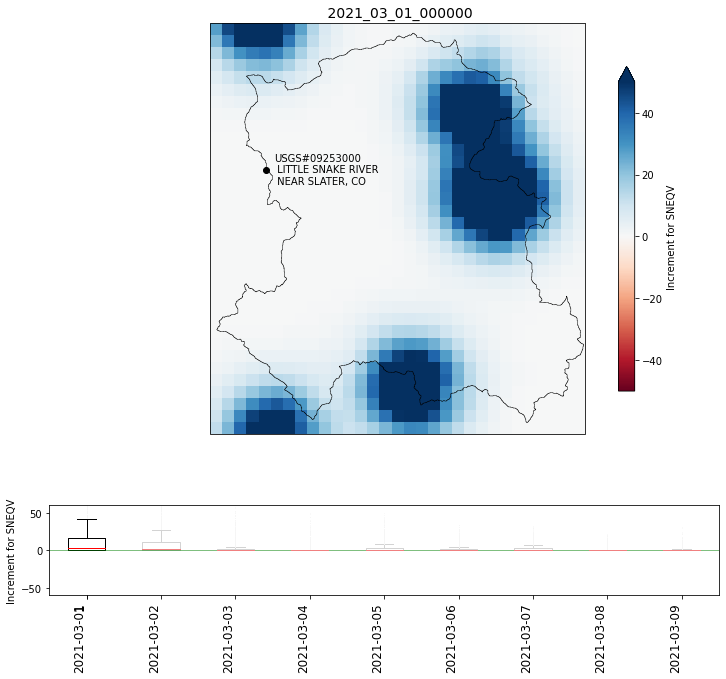

In [3]:
gage_lon = -107.143388
gage_lat = 40.99941048
gage_name = 'USGS#09253000\n LITTLE SNAKE RIVER\n NEAR SLATER, CO'

vv = ds.SNEQV.values
vv = vv.reshape(vv.shape[0], vv.shape[1]*vv.shape[2]).transpose()
data = vv
mask = ~np.isnan(data)
filtered_data = [d[m] for d, m in zip(data.T, mask.T)]

def make_inc_map(t, fold_out, onlyshow=False):
    t_start = time.perf_counter()
    print(str(datetime.now())+' starting t= '+ str(t) )
    all_timesteps = ds.Time
    current_timestep = all_timesteps[t]
    var = ds.isel(Time=t).SNEQV
    date = str(var.Time.values)
    ts = pd.to_datetime(date)
    d = ts.strftime('%Y_%m_%d_%H%M%S')
    #print(str(datetime.now()), ' | [NOTE] Processing ', prefix,'| t=',f'{t:03d}','| date=', d)
    cbar_kwargs={'label':'Increment for SNEQV' , 'shrink':0.79}
    flierprops = dict(marker='+', markerfacecolor=None, markersize=.3,linestyle='none', markeredgecolor='whitesmoke')
    boxprops = dict(color='black')
    medianprops = dict(color='black')

    fig = plt.figure(figsize=(12, 12))
    gs1 = gridspec.GridSpec(8, 1)
    gs1.update(wspace=0.5015, hspace=-.1025) # set the spacing between axes. 
    ax1 = plt.subplot(gs1[0:5],projection=plot_proj)
    ax1.add_feature(basin_boundary, linewidth=.5)
    plt.plot([gage_lon], [gage_lat], color='black', linewidth=2, marker='o', transform=ccrs.PlateCarree())
    plt.text(gage_lon+.01, gage_lat-.01, gage_name,horizontalalignment='left',transform=ccrs.PlateCarree())
    var.plot(ax=ax1, transform=nwm_proj, cmap='RdBu', vmax=50, center=0, add_colorbar=True, cbar_kwargs= cbar_kwargs)
    ax1.set_title(' '+d, fontsize=14)
    # gl = ax1.gridlines(draw_labels=True, linewidth=.5, color='gray', alpha=.5, linestyle='--')
    # gl.ylabels_right = False
    # gl.xlabels_top = False

    x_labels = [str(d).split('T')[0] for d in all_timesteps.values]
    ax2 = plt.subplot(gs1[6:7])
    bxp0 = ax2.boxplot(filtered_data, widths=.5, labels=x_labels,
                    flierprops=flierprops, medianprops=dict(color='lightcoral'), boxprops=dict(color='lightgray'), whiskerprops=dict(color='lightgray'), capprops=dict(color='lightgray'))
    bxp1 = ax2.boxplot(filtered_data[t], widths=.5, positions=[t+1],
                      flierprops=dict(marker=None), medianprops=dict(color='red'), boxprops=dict(color='black'))
    px = plt.setp(ax2.get_xticklabels(), rotation=90, ha="right")
    ax2.axhline( y=0, color='green', linewidth=.5, label='axvline - full height')
    ax2.set_ylabel('Increment for SNEQV')
    ax2.set_ylim((-60,60))
    ax2.tick_params(axis='x', which='major', labelsize=12)
    
    if not onlyshow:
        file_out = fold_out + '/Inc_SNEQV_' + d
        plt.savefig(file_out, bbox_inches='tight')
        plt.close()
        t_finish = time.perf_counter()
        message = str(datetime.now())+' | [Successful] t='+ str(t) + ' | Saved .png to '+ file_out + " | took " + str(round(t_finish - t_start, 2)) + " seconds"
        print(message)    

make_inc_map(t=0 , fold_out="/where/to/save/plot/if/onlyshow/is/false", onlyshow=True)        

This shows that the increments are positive at the very timestep, meaning that the JEDI-DA application increases the SWE in the water model state. In another word, the observations from SNOTEL stations are greater than the priori model SWE state. 